# Check Medication Extraction Strings from an NLP System in the Official Bundesamt für Sicherheit im Gesundheitswesen Drug List (Austria)
### Author: Pablo Lopez-Garcia
### https://github.com/plopezgarcia/one-offs/tree/master/drug-ingredients-matching

This takes a file of a medication extraction proprietary NLP system file as input that looks like:

```
MEDIKATION 
Sortis 80 mg 0-0-1
Thrombo ASS 100 mg 0-1-0
Ramipril 5 mg 1/2-0-0
...
```

And sorts and classifies each drug/ingredient name according to the [official drugs table](https://aspregister.basg.gv.at/aspregister/faces/aspregister.jspx) published by the [Bundesamt für Sicherheit im Gesundheitswesen](http://www.basg.gv.at/) as one of the following:

* **IS_DRUG**: It's a medication contained in the *drugs* dictionary
* **IS_INGREDIENT**: It's a medication contained in the *ingredients* dictionary
* **MISS**: None of the above. Marked for future inspection. In this case, the three closest matches from both dictionaries are attached to later easily evaluate if this could be a spelling mistake.

Example output:

```
| drug                 | status         | suggest1       | suggest2      | suggest3 |
|----------------------|----------------|----------------|---------------|----------|
| abilify              | IS_DRUG        |                |               |          |
| accupro              | IS_DRUG        |                |               |          |
| accuzide             | IS_DRUG        |                |               |          |
| ...                  | ...            |                |               |          |
| acetylsalicylsäure   | IS_INGREDIENT  |                |               |          |
| calcitriol           | IS_INGREDIENT  |                |               |          |
| captopril            | IS_INGREDIENT  |                |               |          |
| ...                  | ...            |                |               |          |
| ursosin              | MISS           | urosin         | urolind       | urbason  |
| uruflo               | MISS           | uroflo         | reflor        | nuflor   |
| usofal               | MISS           | ursofalk       | salofalk      | ulsal    |
| ...                  | ...            |                |               |          |

```

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import re
import difflib

## Extract Drug and Ingredient Dictionaries

We first create two dictionaries (lists) for drugs and ingredients based on the [official drugs table](https://aspregister.basg.gv.at/aspregister/faces/aspregister.jspx) published by the [Bundesamt für Sicherheit im Gesundheitswesen](http://www.basg.gv.at/)

In [2]:
# Download drugs/asp_register.tsv from here: https://aspregister.basg.gv.at/aspregister/faces/aspregister.jspx
drug_table = pd.read_csv('datafiles/asp_register.tsv', sep=',', quotechar='"', header=0, na_filter=False)
print("ROWS:",len(drug_table))
drug_table[5:10]

ROWS: 27412


,Name,Typ,Bezeichnung,Zulassungsnummer,Inhaber/-in,Zulassungsdatum,Wirkstoff,ATC Code,Suchtgift,Psychotrop,...,Verwendung,Arzneimittelkategorie,Zieltierart,Tierkategorie,Anwendungsart,Dosierung,Zielgewebe,Wartezeit,Einheit,Besonderheit
5,Abacavir/Lamivudin Vale 600 mg/300 mg Filmtabl...,Arzneispezialität,Abacavir/Lamivudin Vale 600 mg/300 mg Filmtabl...,137907,"Arcana Arzneimittel GmbH, Hütteldorfer Straße ...",2017-09-26,ABACAVIR HEMISULFAT; LAMIVUDIN,J05AR02,0,0,...,Human,Standardarzneimittel,,,,,,,,
6,ABASAGLAR 100 Einheiten/ml Injektionslösung in...,Arzneispezialität,ABASAGLAR 100 Einheiten/ml Injektionslösung in...,"EU/1/14/944/005-008,010-013","Eli Lilly Regional Operations GmbH, Kölblgasse...",2014-09-09,INSULIN GLARGIN,A10AE04,0,0,...,Human,Biologika,,,,,,,,
7,ABASAGLAR 100 Einheiten/ml Injektionslösung in...,Arzneispezialität,ABASAGLAR 100 Einheiten/ml Injektionslösung in...,"EU/1/14/944/001-004,009","Eli Lilly Regional Operations GmbH, Kölblgasse...",2014-09-09,INSULIN GLARGIN,A10AE04,0,0,...,Human,Biologika,,,,,,,,
8,ABC Lokale Schmerz-Therapie Wärme-Creme 750 Mi...,Arzneispezialität,ABC Lokale Schmerz-Therapie Wärme-Creme 750 Mi...,1-26384,"Beiersdorf AG, Unnastraße 48, 20245 Hamburg, D...",2006-04-28,CAPSAICIN,M02AB,0,0,...,Human,Standardarzneimittel,,,,,,,,
9,ABC Lokale Schmerz-Therapie Wärme-Pflaster Cap...,Arzneispezialität,ABC Lokale Schmerz-Therapie Wärme-Pflaster Cap...,1-24003,"Beiersdorf AG, Unnastraße 48, 20245 Hamburg, D...",2001-02-28,CAPSICI FRUCTUS (AUSZUG),M02AB,0,0,...,Human,Phytoarzneimittel,,,,,,,,


As a first (oversimplified approach) we will just consider the first word of the drug to build the drugs dictionary.

In [3]:
def first_word(string):
    return(string.split(' ', 1)[0])

drug_dict = drug_table['Bezeichnung'].apply(first_word)
drug_dict = drug_dict.str.lower().replace("\"", "")
drug_dict = drug_dict.map(lambda x: x.replace("\"", ""))
drug_dict = drug_dict.drop_duplicates().sort_values()
drug_dict = drug_dict.tolist()
print("DRUGS:", len(drug_dict))
drug_dict[5:10]

DRUGS: 5820


['abacavir/lamivudin', 'abasaglar', 'abc', 'abführtee', 'abies']

For ingredients we perform a basic cleanup and split based on ';' for multi-ingredient drugs and sort them alphabetically.

In [4]:
ingredients_unprocessed = drug_table['Wirkstoff'].unique().tolist()

ingredient_dict = []
for i in ingredients_unprocessed:
    ingredient_dict = ingredient_dict + i.split(';')

ingredient_dict = sorted(set(map(lambda x: x.lower().strip(), ingredient_dict)))
if '' in ingredient_dict:
    ingredient_dict.remove('')
    
print("INGREDIENTS:", len(ingredient_dict))
ingredient_dict[100:105]

INGREDIENTS: 3318


['alanin',
 'albendazol',
 'albiglutid',
 'alchemilla vulgaris (hab)',
 'alchemillae vulgaris herba']

In this last step we use as input a plain text file that contains extracted medication such as the one shown below. Unfortunately, the NLP system and file are proprietary and cannot be publicly shared:

```
MEDIKATION 
Sortis 80 mg 0-0-1
Thrombo ASS 100 mg 0-1-0
Ramipril 5 mg 1/2-0-0
...
```

Medications extracted by the NLP system are not perfect and might contain actual drugs or ingredient names from the official dictionary, aside from "other things". This is done by the code listed below.

In [5]:
%%time
prescribed = pd.read_csv('datafiles/medikament.txt', sep='\t', header=0, na_filter=False)
prescribed = prescribed['MEDIKAMENT'].apply(first_word).drop_duplicates().sort_values()
prescribed = prescribed.str.lower()
prescribed = prescribed.tolist()

drugs = []
status = []
suggest1 = []
suggest2 = []
suggest3 = []

for p in prescribed:
    drugs.append(p)
    if p in drug_dict:
        status.append("IS_DRUG")
        suggest1.append("")
        suggest2.append("")
        suggest3.append("")
    else:
        if p in ingredient_dict:
            status.append("IS_INGREDIENT")
            suggest1.append("")
            suggest2.append("")
            suggest3.append("")
        else:
            status.append("MISS")
            closest_matches = difflib.get_close_matches(p, drug_dict + ingredient_dict)
            try:
                suggest1.append(closest_matches[0])
            except IndexError:
                suggest1.append("")
            try:
                suggest2.append(closest_matches[1])
            except IndexError:
                suggest2.append("")
            try:
                suggest3.append(closest_matches[2])
            except IndexError:
                suggest3.append("")
                
matches = pd.DataFrame(data={'drug':drugs, 'status':status, 'suggest1':suggest1, 'suggest2':suggest2, 'suggest3':suggest3})
matches = matches.sort_values(by=['status', 'drug'])

CPU times: user 1min 44s, sys: 47.7 ms, total: 1min 44s
Wall time: 1min 44s


The end result are extracted medication tagged as:
* **IS_DRUG**: It's a medication contained in the *drugs* dictionary
* **IS_INGREDIENT**: It's a medication contained in the *ingredients* dictionary
* **MISS**: None of the above. Marked for future inspection. In this case, the three closest matches from both dictionaries are attached to later easily evaluate if this could be a spelling mistake.

Total numbers and excerpts below:

In [6]:
drugs = matches[matches.status=='IS_DRUG']
print("DRUGS:", '{}/{}'.format(len(drugs), len(matches)))
drugs.iloc[100:105]

DRUGS: 1120/3299


,drug,status,suggest1,suggest2,suggest3
292,astonin,IS_DRUG,,,
55,atacand,IS_DRUG,,,
57,atacand,IS_DRUG,,,
294,atacand,IS_DRUG,,,
300,atarax,IS_DRUG,,,


In [7]:
ingredients = matches[matches.status=='IS_INGREDIENT']
print("INGREDIENTS:", '{}/{}'.format(len(ingredients), len(matches)))
ingredients.iloc[10:15]

INGREDIENTS: 16/3299


,drug,status,suggest1,suggest2,suggest3
2432,rifampicin,IS_INGREDIENT,,,
2803,thalidomid,IS_INGREDIENT,,,
2840,ticagrelor,IS_INGREDIENT,,,
2844,timolol,IS_INGREDIENT,,,
2901,triazolam,IS_INGREDIENT,,,


In [8]:
misses = matches[matches.status=='MISS']
print("MISSES:", '{}/{}'.format(len(misses), len(matches)))
misses.iloc[60:65]

MISSES: 2163/3299


,drug,status,suggest1,suggest2,suggest3
81,acermin,MISS,acemin,ceremin,acerbine
87,acicolvir,MISS,aciclovir,aciclovir,ganciclovir
88,acilect,MISS,azilect,arileto,varitect
90,acimetin,MISS,acimethin,cimetidin,cimetidin
92,acopt,MISS,lacopat,azopt,aclop


The whole dataframe exported as CSV:

In [9]:
matches.to_csv("coverage.csv", index=False, sep='\t')

This file was later examined by a physician to further subclassify **MISSES** as:
* **MISSPELL**: Most probably a misspelling of a drug/ingredient (check suggestion columns)
* **FALSE_POS**: Clearly nom a drug, ingredient, medication, misspell... but a common German word or very obvious mistake. These should have never been identified as medication by the NLP system. 
* **CHECK**: Looks like a legit drug/ingredient but was not in the dictionaries. Further investigate: does the drug appear in other international dictionaries such as RxNorm?

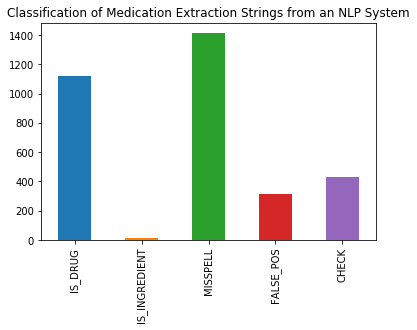

In [11]:
end_counts = pd.Series([len(drugs),len(ingredients),1414,317,432], index=['IS_DRUG', 'IS_INGREDIENT', 'MISSPELL', 'FALSE_POS', 'CHECK'])
end_counts.plot.bar()
plt.title("Classification of Medication Extraction Strings from an NLP System");